In [97]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch
from tqdm.auto import tqdm

In [98]:
def findFiles(path): return glob.glob(path)
print(findFiles("data/names/*.txt"))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [99]:
all_letters = string.ascii_letters + " .,;'?-"
## Here ? is for <EOS>
n_letters = len(all_letters) 
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'?-"

In [100]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [101]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
n_categories, all_categories

(18,
 ['Arabic',
  'Chinese',
  'Czech',
  'Dutch',
  'English',
  'French',
  'German',
  'Greek',
  'Irish',
  'Italian',
  'Japanese',
  'Korean',
  'Polish',
  'Portuguese',
  'Russian',
  'Scottish',
  'Spanish',
  'Vietnamese'])

In [102]:
category_lines["Arabic"][:4]

['Khoury', 'Nahas', 'Daher', 'Gerges']

In [103]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def wordToTensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(wordToTensor("Jones").size())
        

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([5, 1, 59])


In [104]:
wordToTensor("Ann")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

In [142]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size + n_categories, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size + n_categories, output_size)
        self.tanh = nn.Tanh()
        # self.softmax = nn.Softmax(dim=1)
        self.droupout = nn.Dropout(0.02)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)


    def forward(self, category, input_, hidden):
        input_ = torch.cat((category, input_, hidden), dim=1)
        # hidden = self.i2h(input_)
        # output = self.i2o(input_)

        hidden = self.tanh(self.i2h(input_))
        output = self.tanh(self.i2o(input_))
        output_combined = torch.cat((hidden, output), dim=1)
        output = self.o2o(output_combined)
        output = self.droupout(output)
        # output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
HIDDEN_SIZE = 128
model = RNN(n_letters, HIDDEN_SIZE, n_letters)
model

RNN(
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (tanh): Tanh()
  (droupout): Dropout(p=0.02, inplace=False)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
)

## Test run through model

In [143]:
category_tensor = torch.zeros(1, 18)
char_tensor = torch.zeros((1, n_letters))
hidden_tensor = torch.zeros((1, HIDDEN_SIZE))
output, hidden = model(category_tensor, char_tensor, hidden_tensor)
output.shape, hidden.shape

(torch.Size([1, 59]), torch.Size([1, 128]))

In [144]:
category_dict = {}
for v, k in enumerate(all_categories):
    category_dict[k] = v
category_dict

def categoryToTensor(cat):
    tensor = torch.zeros((1, n_categories))
    tensor[0][category_dict[cat]] = 1
    return tensor


categoryToTensor("Russian").shape

torch.Size([1, 18])

## Training the model

In [145]:
wordToTensor("yo").shape
loss = nn.CrossEntropyLoss()
input = torch.tensor([0])
output = torch.tensor([1.2, 1.2, 31.3, 134.4]).reshape(1, -1)
loss(output, input), output.shape, input.shape

(tensor(133.2000), torch.Size([1, 4]), torch.Size([1]))

In [162]:
def define_target(word):
    tensor = [letterToIndex(word[i]) for i in range(1, len(word))]
    tensor.append(letterToIndex('?'))
    return torch.tensor(tensor)

def train_sample(model,
                 optimizer,
                 criterion,
                 input_word,
                 category):
    # model.train()
    optimizer.zero_grad()

    hidden = model.initHidden()
    input_tensor = wordToTensor(input_word)
    category_tensor = categoryToTensor(category)
    target_tensor = define_target(input_word)
    loss = torch.Tensor([0])

    for i in range(input_tensor.size()[0]):
        # print(f"cat {category_tensor.shape}, inp {input_tensor.shape}, hid {hidden_tensor.shape}")
        output, hidden = model(category_tensor, input_tensor[i], hidden)
        # print(f"out {output.shape} tar {target_tensor[i].view(1).shape}")
        l = criterion(output, target_tensor[i].view(1))
        loss += l 

    loss.backward()
    optimizer.step()
    # print(f"The loss: {loss.item()/ input_tensor.size()[0]}")
    return loss.item()/ input_tensor.size()[0]

def train(model,
          optimizer, 
          criterion,
          category_dict):
    losses = []
    for category, word_list in tqdm(category_dict.items()):
        for word in tqdm(word_list):
            loss = train_sample(model=model,
                         optimizer=optimizer,
                         criterion=criterion,
                         input_word=word,
                         category=category)
            losses.append(loss)
        # print(f"The loss: {sum(losses)/ len(losses)}")
    return losses
            


In [163]:
optimizer = torch.optim.Adam(params=model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()
input_word = "Chai"
target_tensor = define_target(input_word)
category = "Russian"

# train_sample(model=model,
#              optimizer=optimizer,
#              criterion=criterion,
#              input_word=input_word,
#              category=category)
losses = []
for i in tqdm(range(1)):
      losses = train(model=model,
            optimizer=optimizer,
            criterion=criterion,
            category_dict=category_lines)
      


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/519 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/3668 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

  0%|          | 0/991 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/9408 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

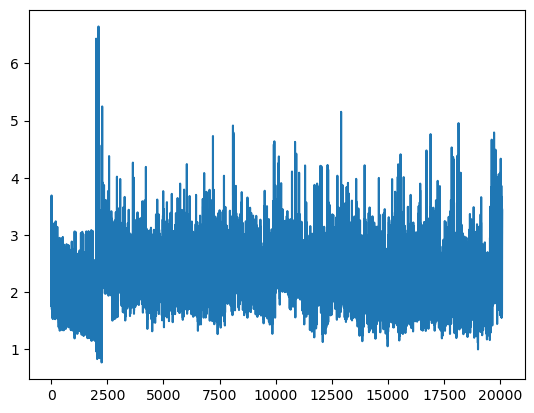

In [164]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)

In [165]:
topv, topi = torch.tensor([1, 2, 3, 1]).topk(1)
topv, topi

(tensor([3]), tensor([2]))

In [174]:
def sample(model,
           initial_letter,
           category,
           word_limit = 10):
    with torch.no_grad():
        word = initial_letter
        category_tensor = categoryToTensor(category)
        initial_letter_tensor = letterToTensor(initial_letter)
        hidden = model.initHidden()

        while len(word) < word_limit:
            output, hidden = model(category_tensor, initial_letter_tensor, hidden)
            topv, topi = output.topk(1)
            output_letter = all_letters[topi]
            initial_letter_tensor = letterToTensor(output_letter)
            word += output_letter
            if output_letter == '?':
                break
        print(word)
            
sample(model=model,
       category="Russian",
       initial_letter='R',
       word_limit=10)

sample(model=model,
       category="Chinese",
       initial_letter='D',
       word_limit=10)

Rakov?
Dun?
